In [1]:
#for pytorch we can inport using 
from torchvision import transforms # transform helfs us to to preprocessing
from torchvision.transforms import Compose
import torchvision.transforms as transforms, torchvision, matplotlib.pyplot as plt
# fORWARD pass using ALS
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt







In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True,
                                        transform=transform)

Files already downloaded and verified


In [6]:
transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),  # Resize to 256x256 pixels to improve resolution
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1), # from[0,1], tot 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# pixel-mean/std
])


In [7]:
#make data_loader
data_loader=DataLoader(trainset,batch_size=64,shuffle=True)
# Get a batch of images and labels
images, labels = next(iter(data_loader))

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64])


In [11]:
import torch
import numpy as np

class DiffusionForward:
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, s=0.008, schedule_type='linear', noise_type='gaussian'):
        self.timesteps = timesteps
        self.noise_type = noise_type  # Store the noise type
        self.schedule_type = schedule_type 
        self.s = s
        # Store the schedule type
        
        # Create the beta schedule based on the selected schedule type
        if schedule_type == 'linear':
            self.betas = self.linear(beta_start, beta_end, timesteps)
        elif schedule_type == 'cosine':
            self.betas = self.cosine(timesteps,s)
        elif schedule_type == 'quadratic':
            self.betas = self.quadratic(beta_start, beta_end, timesteps)
        elif schedule_type == 'sigmoid':
            self.betas = self.sigmoid(beta_start, beta_end, timesteps)
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")
        
        # Precompute alpha values
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)  
        
    def linear(self, beta_start, beta_end, timesteps):
        return torch.linspace(beta_start, beta_end, timesteps)

    def cosine(self, s,timesteps):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + self.s) / (1 + self.s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)
    
    def sigmoid(self, beta_start, beta_end, timesteps):
        betas = torch.linspace(-6, 6, timesteps)
        return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
   
    
    def quadratic(self, beta_start, beta_end, timesteps):
        return torch.linspace(beta_start ** 0.5, beta_end ** 0.5, timesteps) ** 2

    def add_noise(self, x):
        if self.noise_type == 'gaussian':
            return torch.randn_like(x)  # Gaussian noise
        elif self.noise_type == 'uniform':
            return torch.rand_like(x) * 2 - 1  # Uniform noise [-1, 1]
        elif self.noise_type == 'laplace':
            return torch.distributions.Laplace(0, 1).sample(x.shape).to(x.device)  # Laplacian noise  # Salt and pepper noise
        else:
            raise ValueError(f"Unknown noise type: {self.noise_type}")
    def forward(self, x, t):
        if isinstance(t, int):
            t = torch.tensor([t], dtype=torch.long, device=x.device)
        
            batch_size = x.shape[0]
            alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)  # Shape to match the input

        # Sample noise based on the noise type
            noise = self.add_noise(x)
        
        # Add noise according to the forward process
            noisy_image = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
            return noisy_image

        



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

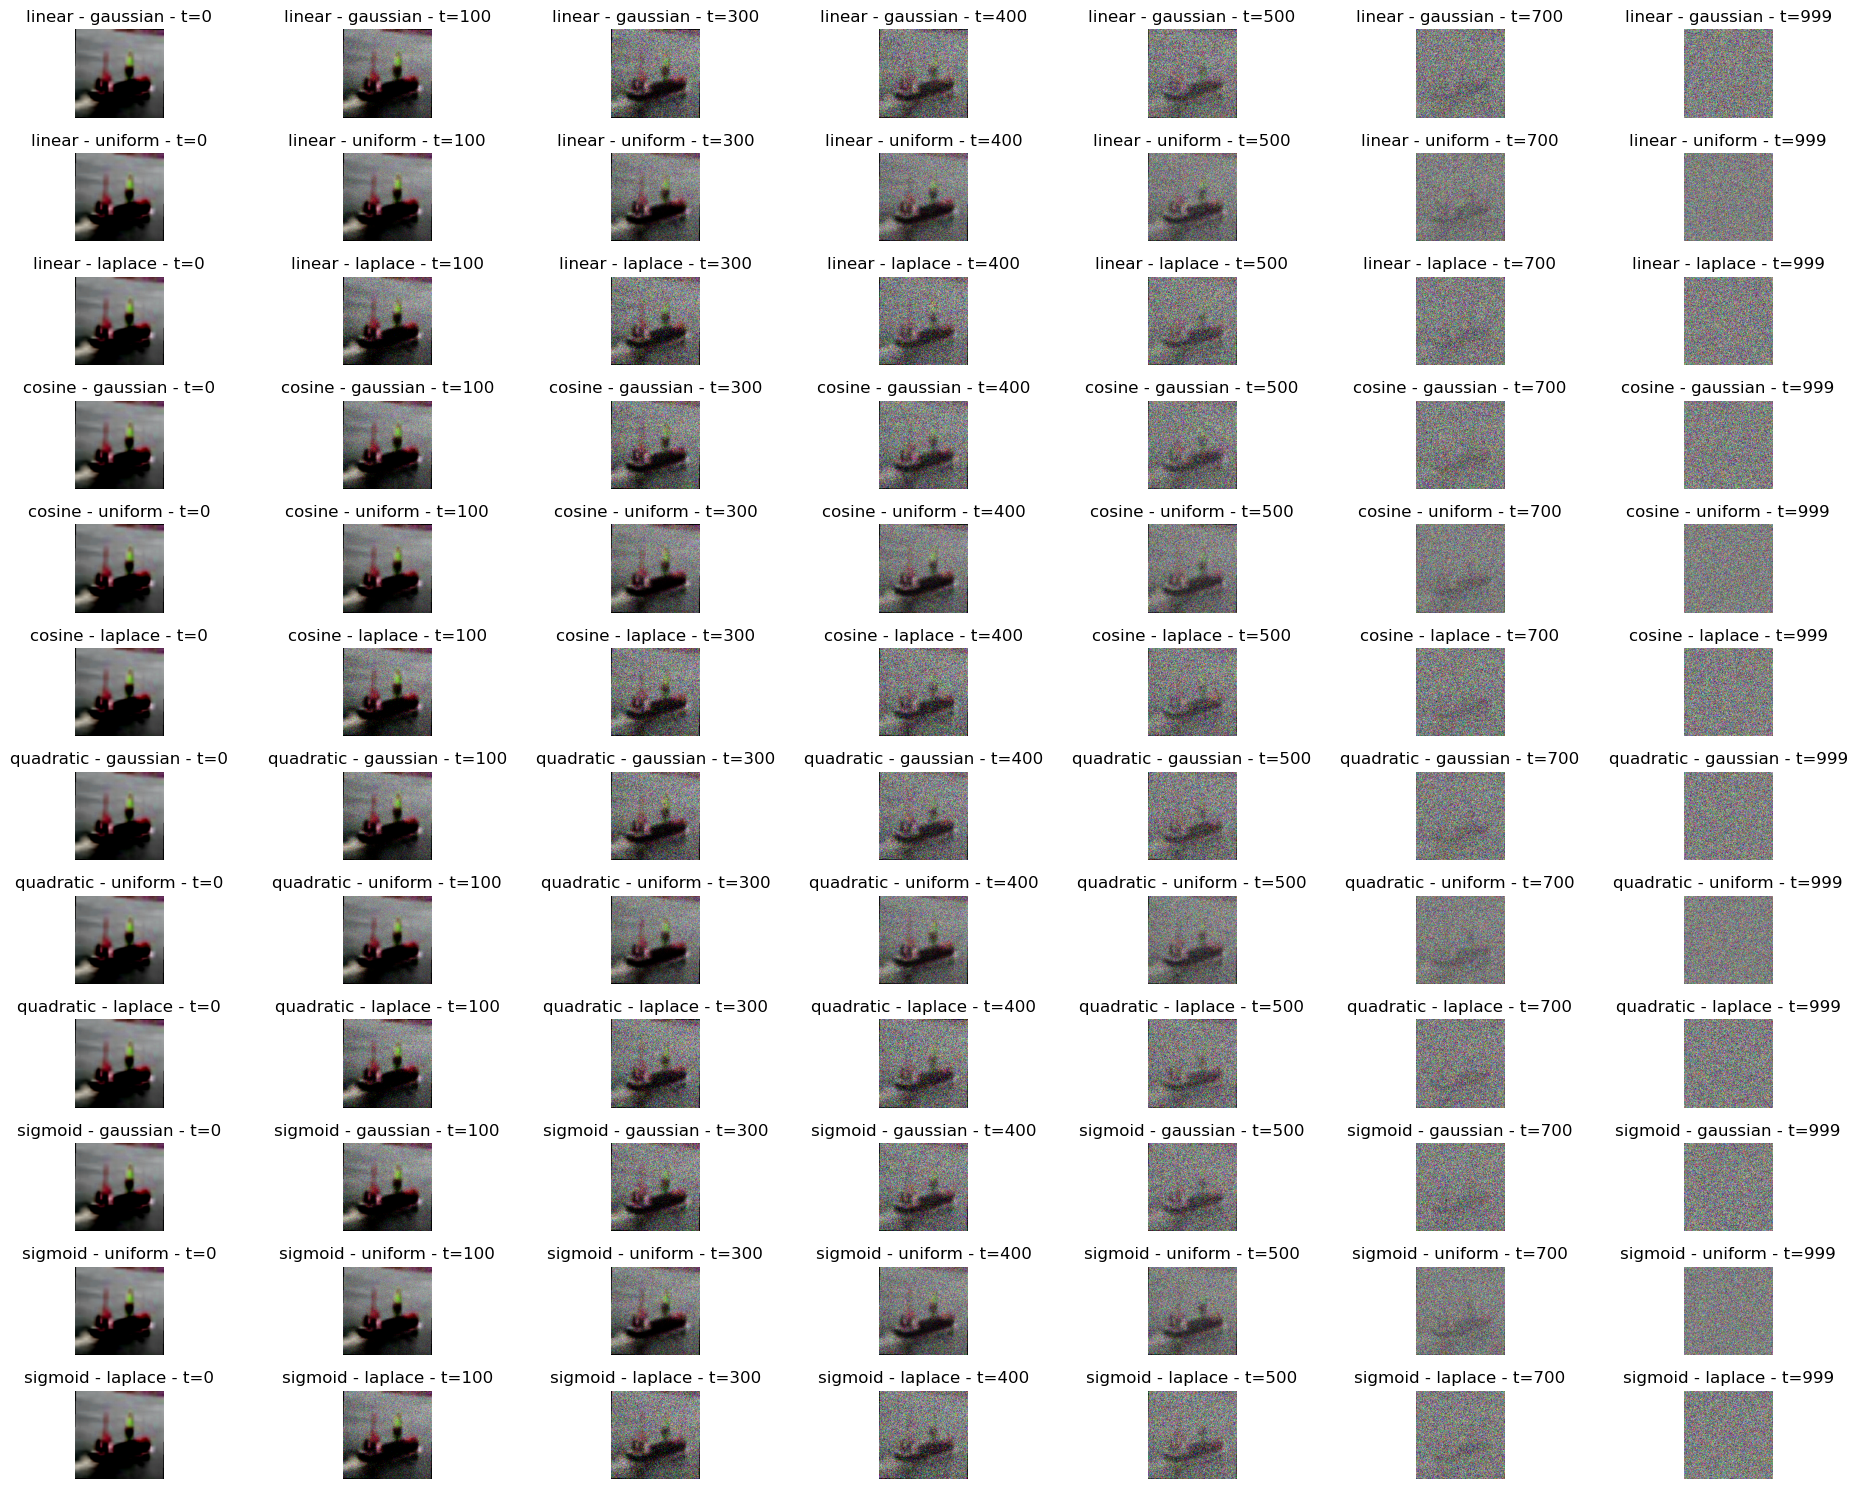

In [12]:
import matplotlib.pyplot as plt

# Function to plot images with different noise types for each beta schedule at specified timesteps
def plot_noise_combinations(diffusion, original_image, timesteps=[0, 100, 300,400,500, 700, 999]):
    noise_types = ['gaussian', 'uniform', 'laplace']
    schedule_types = ['linear', 'cosine', 'quadratic', 'sigmoid']
    
    # Create subplots: each row represents a unique combination of schedule type and noise type
    fig, axs = plt.subplots(len(schedule_types) * len(noise_types), len(timesteps), figsize=(20, 15))
    
    for row, schedule in enumerate(schedule_types):
        for col, noise in enumerate(noise_types):
            # Update the beta schedule and noise type
            diffusion.schedule_type = schedule
            diffusion.noise_type = noise
            
            for t_idx, t in enumerate(timesteps):
                # Generate noisy images at different timesteps
                noisy_image = diffusion.forward(original_image, t)

                # Plot the noisy image
                axs[row * len(noise_types) + col, t_idx].imshow(noisy_image.squeeze().permute(1, 2, 0).cpu().numpy() / 2 + 0.5)  # Unnormalize
                axs[row * len(noise_types) + col, t_idx].set_title(f'{schedule} - {noise} - t={t}')
                axs[row * len(noise_types) + col, t_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch of images from the DataLoader to use for the plots
images, _ = next(iter(data_loader))
original_image = images[0].unsqueeze(0)  # Take the first image and add a batch dimension

# Instantiate the DiffusionForward class
diffusion = DiffusionForward(timesteps=1000)

# Plot combinations of beta schedules and noise types
plot_noise_combinations(diffusion, original_image)


In [13]:
import torch

# Function to calculate and display mean and standard deviation for each combination
def analyze_noise_combinations(diffusion, original_image, timesteps=[0, 100, 500, 700, 999]):
    noise_types = ['gaussian', 'uniform', 'laplace' ]
    schedule_types = ['linear', 'cosine', 'quadratic', 'sigmoid']
    
    results = {}
    
    for schedule in schedule_types:
        for noise in noise_types:
            # Update the beta schedule and noise type
            diffusion.schedule_type = schedule
            diffusion.noise_type = noise
            
            # Generate the noisy image at the last timestep
            last_timestep = timesteps[-1]
            noisy_image = diffusion.forward(original_image, last_timestep)

            # Calculate mean and std
            mean = torch.mean(noisy_image).item()
            std = torch.std(noisy_image).item()

            # Store results
            results[(schedule, noise)] = (mean, std)
    
    return results
original_image = images[0].unsqueeze(0)  # Take the first image and add a batch dimension

# Instantiate the DiffusionForward class
diffusion = DiffusionForward(timesteps=1000)

# Perform analysis of noise combinations
analysis_results = analyze_noise_combinations(diffusion, original_image)

# Print the results in a structured format
for (schedule, noise), (mean, std) in analysis_results.items():
    print(f'Schedule: {schedule}, Noise: {noise} -> Mean: {mean:.4f}, Std: {std:.4f}')


Schedule: linear, Noise: gaussian -> Mean: -0.0093, Std: 1.0014
Schedule: linear, Noise: uniform -> Mean: -0.0057, Std: 0.5780
Schedule: linear, Noise: laplace -> Mean: -0.0032, Std: 1.4112
Schedule: cosine, Noise: gaussian -> Mean: -0.0024, Std: 1.0002
Schedule: cosine, Noise: uniform -> Mean: -0.0019, Std: 0.5779
Schedule: cosine, Noise: laplace -> Mean: -0.0017, Std: 1.4179
Schedule: quadratic, Noise: gaussian -> Mean: -0.0054, Std: 0.9999
Schedule: quadratic, Noise: uniform -> Mean: -0.0029, Std: 0.5777
Schedule: quadratic, Noise: laplace -> Mean: -0.0000, Std: 1.4142
Schedule: sigmoid, Noise: gaussian -> Mean: -0.0043, Std: 0.9979
Schedule: sigmoid, Noise: uniform -> Mean: -0.0063, Std: 0.5764
Schedule: sigmoid, Noise: laplace -> Mean: -0.0031, Std: 1.4081
